## Notebook Overview
- Load the enriched cohort and build race-specific masks for structured and text features.
- Retrain paired MLPs (without vs with race) across multiple runs, storing predictions to disk.
- Aggregate probability outputs to compute race-level performance and calibration metrics.
- Visualize confusion matrices, ROC curves, and calibration plots for both model variants.
- Use SHAP to interpret feature contributions in the race-aware network and summarize findings.


In [ ]:
from helper_functions.nn import create_nn
from helper_functions.notebook_utils import BinaryExpectedCalibrationError, equate_weights, train_simultaneously


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

import tensorflow as tf

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_rel
import seaborn as sns


from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline

from keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.initializers import GlorotUniform

import keras.backend as K
from sklearn.calibration import calibration_curve

import h5py
import shutil

import os

In [4]:
save_dir = 'experiments_data/'

save_path = os.path.join(save_dir, 'data_variables.npz')

# Load variables back from the .npz file
loaded_data = np.load(save_path, allow_pickle=True)
X_train = loaded_data['X_train']
X_test = loaded_data['X_test']
Y_train = loaded_data['Y_train']
Y_test = loaded_data['Y_test']
X_train_num = loaded_data['X_train_num']
X_test_num = loaded_data['X_test_num']
X_train_encoded = loaded_data['X_train_encoded']
X_test_encoded = loaded_data['X_test_encoded']

races = ['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE']

print("Variables loaded successfully")

masks_hdf5_name = 'baseline_masks.h5'

mask_path = save_dir + masks_hdf5_name

loaded_masks = {}

with h5py.File(mask_path, 'r') as hdf:
    for race in hdf.keys():  # Iterate over the keys (which are the race names)
        loaded_masks[race] = np.array(hdf[race])  # Load each dataset as a NumPy array

masks = loaded_masks

Variables loaded successfully


/var/folders/sk/8z_2wkxn7hx2ytzbzxsgwdjm0000gn/T/ipykernel_48022/1903674169.py:28: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loaded_masks[race] = np.array(hdf[race])  # Load each dataset as a NumPy array


In [4]:
masks_train = {race: X_train_num[:, -5+j] == 1 for j, race in enumerate(races)}
masks_test = {race: X_test_num[:, -5+j] == 1 for j, race in enumerate(races)}

# Get proportion of test set labels for each race

y_test_prop = {race: (np.mean(Y_test[masks_test[race]]))*100 for race in races}
y_train_prop = {race: (np.mean(Y_train[masks_train[race]]))*100 for race in races}

print('Admssion Proportions by Race')
for race in races:
    print(f'{race}: {round(y_train_prop[race], 2)}% of training set, {round(y_test_prop[race], 2)}% of validation set')

Admssion Proportions by Race
ASIAN: 31.18% of training set, 31.06% of validation set
BLACK: 28.72% of training set, 28.37% of validation set
HISPANIC: 24.97% of training set, 25.06% of validation set
OTHER: 30.5% of training set, 30.25% of validation set
WHITE: 43.41% of training set, 43.5% of validation set


In [5]:
df = pd.read_csv('combined_w_age_and_insurance.csv', index_col=0)
df

,subject_id,stay_id,hadm_id,intime,outtime,time_of_day,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,gender,race,arrival_transport,chiefcomplaint,disposition,insurance_type,age
0,10000032,32952584,29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,16.40,97.8,87.0,14.0,97.0,71.0,43.0,2.0,F,WHITE,AMBULANCE,Hypotension,N,Medicaid,52
1,10000032,33258284,22595853.0,2180-05-06 19:17:00,2180-05-06 23:30:00,19.28,98.4,70.0,16.0,97.0,106.0,63.0,3.0,F,WHITE,AMBULANCE,"Abd pain, Abdominal distention",A,Medicaid,52
2,10000032,35968195,25742920.0,2180-08-05 20:58:00,2180-08-06 01:44:00,20.97,99.4,105.0,18.0,96.0,106.0,57.0,3.0,F,WHITE,AMBULANCE,"n/v/d, Abd pain",A,Medicaid,52
3,10000032,38112554,22841357.0,2180-06-26 15:54:00,2180-06-26 21:31:00,15.90,98.9,88.0,18.0,97.0,116.0,88.0,3.0,F,WHITE,AMBULANCE,Abdominal distention,A,Medicaid,52
4,10000032,39399961,29079034.0,2180-07-23 05:54:00,2180-07-23 14:00:00,5.90,98.7,77.0,16.0,98.0,96.0,50.0,2.0,F,WHITE,AMBULANCE,"Abdominal distention, Abd pain, LETHAGIC",A,Medicaid,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376206,19999784,34149746,25715748.0,2119-08-11 09:15:00,2119-08-11 13:40:00,9.25,98.8,92.0,18.0,100.0,122.0,77.0,3.0,M,BLACK,WALK IN,Wound eval,A,Medicaid,57
376207,19999784,35692999,26194817.0,2119-06-18 14:21:00,2119-06-18 21:09:29,14.35,98.6,80.0,18.0,100.0,161.0,100.0,3.0,M,BLACK,WALK IN,L Leg weakness,A,Medicaid,57
376208,19999784,37972930,24935234.0,2119-07-09 17:38:00,2119-07-10 00:04:00,17.63,98.0,91.0,16.0,99.0,148.0,90.0,2.0,M,BLACK,WALK IN,Abnormal MRI,A,Medicaid,57
376209,19999828,30712109,29734428.0,2147-07-17 17:18:00,2147-07-18 17:34:00,17.30,98.1,83.0,18.0,100.0,107.0,75.0,2.0,F,WHITE,WALK IN,"Abd pain, Wound eval",A,Medicaid,46


In [ ]:
for race in races:
    df_race = df[df['race'] == race]
    # Get the number of columns where disposition == 'A' over the total number of rows
    dispo = df_race['disposition'].value_counts(normalize=True)
    print(f'{race}: Admitted {dispo["A"]*100:.2f}%, Not Admitted {dispo["N"]*100:.2f}%')

ASIAN: Admitted 31.14%, Not Admitted 68.86%
BLACK: Admitted 28.61%, Not Admitted 71.39%
HISPANIC: Admitted 25.00%, Not Admitted 75.00%
OTHER: Admitted 30.42%, Not Admitted 69.58%
WHITE: Admitted 43.44%, Not Admitted 56.56%


In [5]:
seed = 42
epochs = 3
batch_size = 32

model1 = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1] - 5, seed=seed)
model2 = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1], seed=seed)

model1, model2 = equate_weights(model1, model2, verbose=False)

optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = BinaryExpectedCalibrationError(num_bins=10)

train_simultaneously(
    X_train_num, X_train_encoded, Y_train,
    X_test_num, X_test_encoded, Y_test,
    model1, model2, optimizer1, optimizer2, loss_fn, epochs=epochs, batch_size=batch_size
)

probs_no_race = model1.predict([X_test_num[:, :-5], X_test_encoded])
probs_with_race = model2.predict([X_test_num, X_test_encoded])

Epoch 1/3


100%|██████████| 8230/8230 [02:41<00:00, 51.00it/s]


Epoch 1:
- Training Loss model 1 (no race): 0.17100000381469727
- Training Loss model 2 (race included): 0.17100000381469727
- Training Accuracy model 1: 75.04%
- Training Accuracy model 2: 75.07%
- Test Loss model 1 (no race): 0.17100000381469727
- Test Loss model 2 (race included): 0.17299999296665192
- Test Accuracy model 1: 76.40%
- Test Accuracy model 2: 76.43%
Epoch 2/3


100%|██████████| 8230/8230 [02:43<00:00, 50.42it/s]


Epoch 2:
- Training Loss model 1 (no race): 0.17000000178813934
- Training Loss model 2 (race included): 0.17000000178813934
- Training Accuracy model 1: 76.89%
- Training Accuracy model 2: 76.94%
- Test Loss model 1 (no race): 0.1720000058412552
- Test Loss model 2 (race included): 0.17000000178813934
- Test Accuracy model 1: 76.75%
- Test Accuracy model 2: 76.61%
Epoch 3/3


100%|██████████| 8230/8230 [02:44<00:00, 50.01it/s]


Epoch 3:
- Training Loss model 1 (no race): 0.16899999976158142
- Training Loss model 2 (race included): 0.16899999976158142
- Training Accuracy model 1: 77.21%
- Training Accuracy model 2: 77.20%
- Test Loss model 1 (no race): 0.1679999977350235
- Test Loss model 2 (race included): 0.16899999976158142
- Test Accuracy model 1: 76.80%
- Test Accuracy model 2: 76.81%
   1/3527 [..............................] - ETA: 11:12

2025-09-26 10:25:15.892787: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3527/3527 [==============================] - 1s 382us/step


In [66]:
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score, accuracy_score,
    precision_score, recall_score
)

from sklearn.calibration import calibration_curve


ece_metric = BinaryExpectedCalibrationError(num_bins=10)

def compute_metrics(y_true, y_prob):
    y_true_tf = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_prob_tf = tf.convert_to_tensor(y_prob, dtype=tf.float32)
    ece = ece_metric(y_true_tf, y_prob_tf).numpy()

    y_pred = y_prob > 0.5
    acc = accuracy_score(y_true, y_pred)
    sens = recall_score(y_true, y_pred)
    spec = recall_score(1 - y_true, 1 - y_pred)

    return acc, sens, spec, ece

In [68]:
loaded_data = np.load('experiments_data/baseline_predictions_50.npz')

In [75]:
probs_no_race = loaded_data['probs_no_race']
probs_with_race = loaded_data['probs_with_race']

probs_no_race = probs_no_race.mean(axis=0)
probs_with_race = probs_with_race.mean(axis=0)

Race: ASIAN

 No Race:
  - Accuracy: 0.8012
  - Sensitivity: 0.5863
  - Specificity: 0.8980
  - ECE: 0.0381

 With Race:
  - Accuracy: 0.8008
  - Sensitivity: 0.5759
  - Specificity: 0.9021
  - ECE: 0.0420
Race: BLACK

 No Race:
  - Accuracy: 0.7879
  - Sensitivity: 0.5476
  - Specificity: 0.8831
  - ECE: 0.0454

 With Race:
  - Accuracy: 0.7916
  - Sensitivity: 0.4950
  - Specificity: 0.9091
  - ECE: 0.0390
Race: HISPANIC

 No Race:
  - Accuracy: 0.8027
  - Sensitivity: 0.5072
  - Specificity: 0.9015
  - ECE: 0.0497

 With Race:
  - Accuracy: 0.8061
  - Sensitivity: 0.4102
  - Specificity: 0.9385
  - ECE: 0.0402
Race: OTHER

 No Race:
  - Accuracy: 0.8089
  - Sensitivity: 0.5950
  - Specificity: 0.9017
  - ECE: 0.0374

 With Race:
  - Accuracy: 0.8077
  - Sensitivity: 0.5899
  - Specificity: 0.9021
  - ECE: 0.0389
Race: WHITE

 No Race:
  - Accuracy: 0.7522
  - Sensitivity: 0.6601
  - Specificity: 0.8231
  - ECE: 0.0518

 With Race:
  - Accuracy: 0.7530
  - Sensitivity: 0.6879
  - Spe

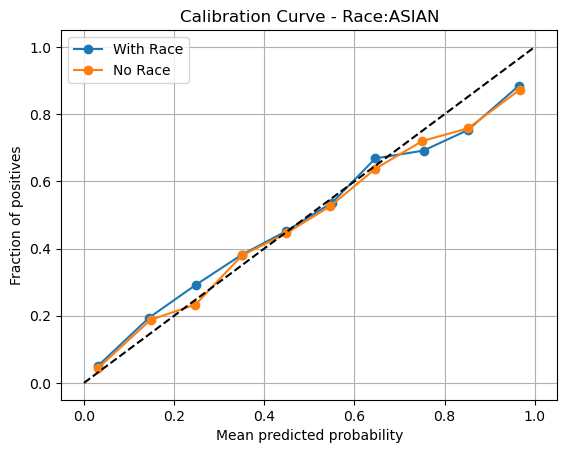

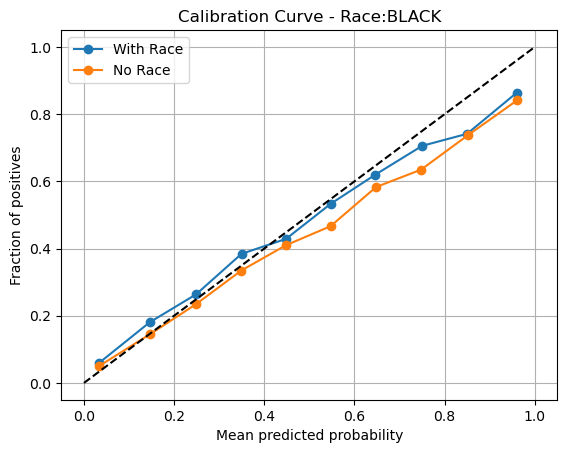

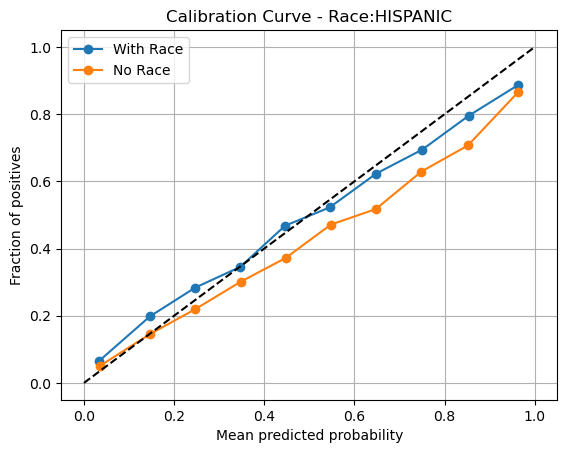

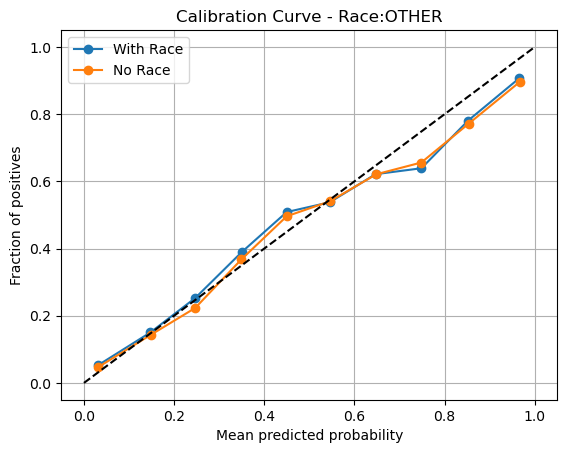

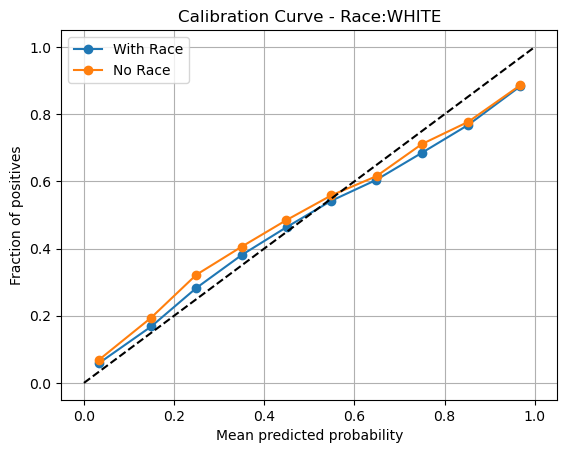

In [76]:
for race in masks:
    idx = masks[race]
    y_true = Y_test[idx]
    
    y_prob_with_race = probs_with_race[idx]
    y_prob_no_race = probs_no_race[idx]
    

    acc, sens, spec, ece = compute_metrics(y_true, y_prob_no_race)
    print(f"Race: {race}")
    print(f'\n No Race:')
    print(f"  - Accuracy: {acc:.4f}")
    print(f"  - Sensitivity: {sens:.4f}")
    print(f"  - Specificity: {spec:.4f}")
    print(f"  - ECE: {ece:.4f}")
    
    acc, sens, spec, ece = compute_metrics(y_true, y_prob_with_race)
    print(f'\n With Race:')
    print(f"  - Accuracy: {acc:.4f}")
    print(f"  - Sensitivity: {sens:.4f}")
    print(f"  - Specificity: {spec:.4f}")
    print(f"  - ECE: {ece:.4f}")
    
for race in masks:
    idx = masks[race]
    y_true = Y_test[idx]
    
    y_prob_with_race = probs_with_race[idx]
    y_prob_no_race = probs_no_race[idx]
    
    plt.figure()
    prob_true, prob_pred_with_race = calibration_curve(y_true, y_prob_with_race, n_bins=10, strategy='uniform')    
    plt.plot(prob_pred_with_race, prob_true, marker='o', label='With Race')
    
    prob_true, prob_pred_no_race = calibration_curve(y_true, y_prob_no_race, n_bins=10, strategy='uniform')
    plt.plot(prob_pred_no_race, prob_true, marker='o', label='No Race')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curve - Race:{race}")
    plt.legend()
    plt.grid()
    plt.show()


[No Race - Full Dataset]
  - Accuracy: 0.7670
  - Sensitivity: 0.5828
  - Specificity: 0.8761
  - ECE: 0.0568
  - AUROC: 0.8398


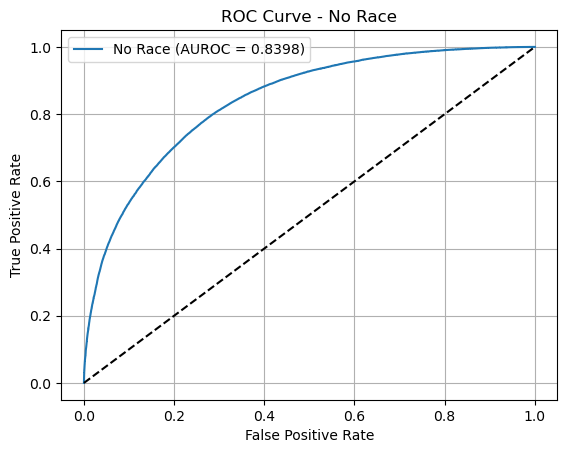

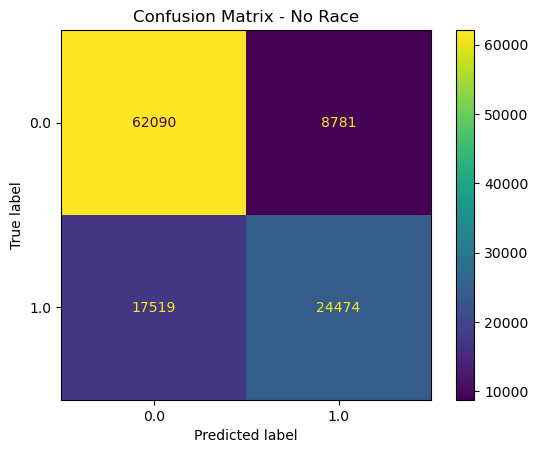


[With Race - Full Dataset]
  - Accuracy: 0.7682
  - Sensitivity: 0.5849
  - Specificity: 0.8768
  - ECE: 0.0449
  - AUROC: 0.8407


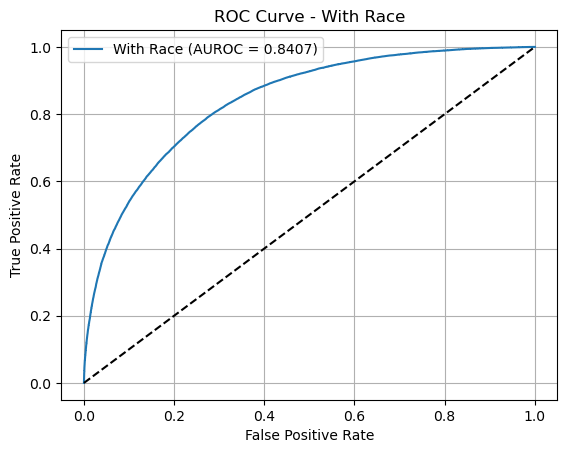

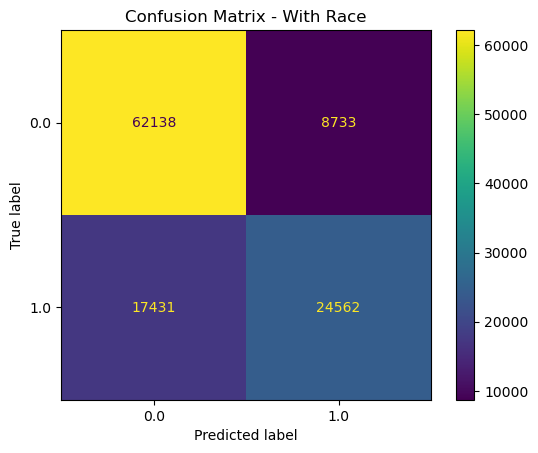

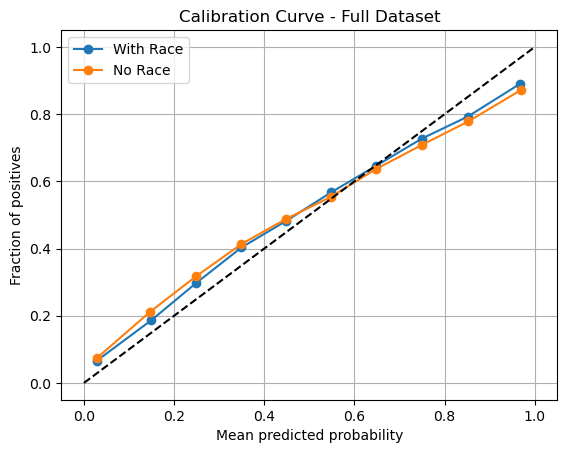

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = Y_test
y_prob_with_race = probs_with_race
y_prob_no_race = probs_no_race

# No Race
acc, sens, spec, ece = compute_metrics(y_true, y_prob_no_race)
auc = roc_auc_score(y_true, y_prob_no_race)
print("\n[No Race - Full Dataset]")
print(f"  - Accuracy: {acc:.4f}")
print(f"  - Sensitivity: {sens:.4f}")
print(f"  - Specificity: {spec:.4f}")
print(f"  - ECE: {ece:.4f}")
print(f"  - AUROC: {auc:.4f}")

# ROC curve - No Race
fpr, tpr, _ = roc_curve(y_true, y_prob_no_race)
plt.figure()
plt.plot(fpr, tpr, label=f'No Race (AUROC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - No Race")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix - No Race
y_pred = y_prob_no_race > 0.5
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title("Confusion Matrix - No Race")
plt.grid(False)
plt.show()

# With Race
acc, sens, spec, ece = compute_metrics(y_true, y_prob_with_race)
auc = roc_auc_score(y_true, y_prob_with_race)
print("\n[With Race - Full Dataset]")
print(f"  - Accuracy: {acc:.4f}")
print(f"  - Sensitivity: {sens:.4f}")
print(f"  - Specificity: {spec:.4f}")
print(f"  - ECE: {ece:.4f}")
print(f"  - AUROC: {auc:.4f}")

# ROC curve - With Race
fpr, tpr, _ = roc_curve(y_true, y_prob_with_race)
plt.figure()
plt.plot(fpr, tpr, label=f'With Race (AUROC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - With Race")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix - With Race
y_pred = y_prob_with_race > 0.5
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title("Confusion Matrix - With Race")
plt.grid(False)
plt.show()


plt.figure()
prob_true, prob_pred_with_race = calibration_curve(y_true, y_prob_with_race, n_bins=10, strategy='uniform')    
plt.plot(prob_pred_with_race, prob_true, marker='o', label='With Race')

prob_true, prob_pred_no_race = calibration_curve(y_true, y_prob_no_race, n_bins=10, strategy='uniform')
plt.plot(prob_pred_no_race, prob_true, marker='o', label='No Race')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title(f"Calibration Curve - Full Dataset")
plt.legend()
plt.grid()
plt.show()


/Users/aidanlicoppe/miniconda3/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


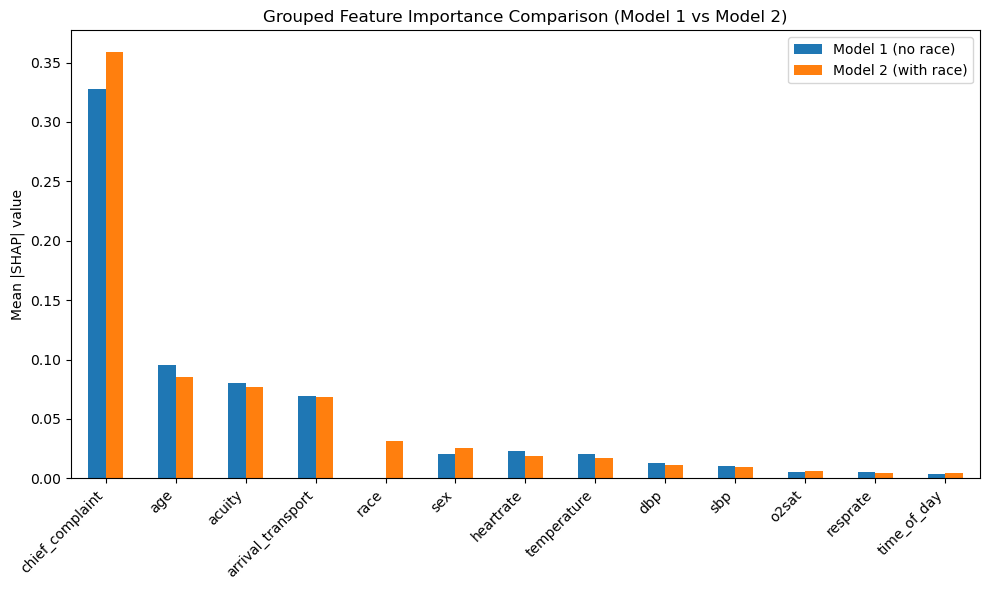

In [6]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Feature names (keep as you had)
# -----------------------------
structured_feature_names = [
    # text placeholder (keep for labeling)
    'chief_complaint',
    # numeric
    'time_of_day','temperature','heartrate','resprate',
    'o2sat','sbp','dbp','acuity','age',
    # categorical one-hot
    'gender_F','gender_M',
    'arrival_transport_AMBULANCE','arrival_transport_WALK IN',
    'race_ASIAN','race_BLACK','race_HISPANIC','race_OTHER','race_WHITE'
]

# Create a structured-only list (no text) to match X_test_num columns
struct_only_names = [f for f in structured_feature_names if f != 'chief_complaint']

race_features = ['race_ASIAN','race_BLACK','race_HISPANIC','race_OTHER','race_WHITE']
gender_features = ['gender_F','gender_M']
arrival_features = ['arrival_transport_AMBULANCE','arrival_transport_WALK IN']

# -----------------------------
# 2. SHAP importance function (text aggregated to single scalar)
# -----------------------------
def get_shap_importance(model, X_structured, X_text, feature_names_with_text,
                        sample_size=200, background_size=100):
    """
    feature_names_with_text: list where first element MUST be 'chief_complaint'
                             and the rest correspond to columns of X_structured.
    """
    # sample
    n = min(sample_size, X_structured.shape[0])
    idx = np.random.choice(X_structured.shape[0], n, replace=False)
    X_struct_sample = X_structured[idx]
    X_text_sample = X_text[idx]

    # background
    bbg_n = min(background_size, X_structured.shape[0])
    bkg_idx = np.random.choice(X_structured.shape[0], bbg_n, replace=False)
    X_struct_background = X_structured[bkg_idx]
    X_text_background = X_text[bkg_idx]

    # GradientExplainer with both inputs
    explainer = shap.GradientExplainer(model, [X_struct_background, X_text_background])
    shap_values = explainer.shap_values([X_struct_sample, X_text_sample])

    # structured SHAP (first input)
    shap_struct = shap_values[0]        
    mean_abs_struct = np.abs(shap_struct).mean(axis=0)  
    mean_abs_struct = list(mean_abs_struct.flatten())

    # text SHAP (second input) -> aggregate into single scalar
    shap_text = shap_values[1]
    mean_abs_text_by_token = np.abs(shap_text).mean(axis=0)  
    mean_abs_text_total = mean_abs_text_by_token.sum()
    mean_abs_text_total = list(mean_abs_text_total.flatten())

    # combine: first element = text aggregate, then structured features
    combined = mean_abs_text_total + mean_abs_struct

    # sanity check lengths
    if len(combined) != len(feature_names_with_text):
        raise ValueError(f"Length mismatch: combined SHAP has {len(combined)} entries "
                         f"but feature_names_with_text has {len(feature_names_with_text)}")

    return dict(zip(feature_names_with_text, combined))

# -----------------------------
# 3. Group encoded features
# -----------------------------
def group_encoded_features(imp_dict, include_race=True):
    grouped = {}
    # text group
    if "chief_complaint" in imp_dict:
        grouped["chief_complaint"] = imp_dict["chief_complaint"]
    # numeric
    for f in ['time_of_day','temperature','heartrate','resprate',
              'o2sat','sbp','dbp','acuity','age']:
        if f in imp_dict:
            grouped[f] = imp_dict[f]
    # categorical collapsed
    grouped['sex'] = sum(imp_dict[f] for f in gender_features if f in imp_dict)
    grouped['arrival_transport'] = sum(imp_dict[f] for f in arrival_features if f in imp_dict)
    if include_race:
        grouped['race'] = sum(imp_dict[f] for f in race_features if f in imp_dict)
    return grouped

# -----------------------------
# 4. Prepare inputs for Model 1 (no race)
# -----------------------------
# mask based on struct_only_names (matches X_test_num columns)
mask_no_race = [f not in race_features for f in struct_only_names]
X_test_no_race = X_test_num[:, mask_no_race]
feature_names_no_race_struct = [f for f in struct_only_names if f not in race_features]

# feature name lists used for zipping in get_shap_importance:
# first element must be 'chief_complaint', then the structured column names used in X_structured.
feature_names_model1 = ['chief_complaint'] + feature_names_no_race_struct
feature_names_model2 = ['chief_complaint'] + struct_only_names

# -----------------------------
# 5. Compute SHAP values
# -----------------------------
imp1 = get_shap_importance(model1,
                           X_structured=X_test_no_race,
                           X_text=X_test_encoded,
                           feature_names_with_text=feature_names_model1)

imp2 = get_shap_importance(model2,
                           X_structured=X_test_num,
                           X_text=X_test_encoded,
                           feature_names_with_text=feature_names_model2)

# group them
imp1_grouped = group_encoded_features(imp1, include_race=False)
imp2_grouped = group_encoded_features(imp2, include_race=True)

# -----------------------------
# 6. DataFrame for plotting
# -----------------------------
df = pd.DataFrame([imp1_grouped, imp2_grouped],
                  index=['Model 1 (no race)', 'Model 2 (with race)']).T

df_sorted = df.sort_values(by='Model 2 (with race)', ascending=False)

# -----------------------------
# 7. Plot side by side
# -----------------------------
df_sorted.plot(kind='bar', figsize=(10,6))
plt.ylabel("Mean |SHAP| value")
plt.title("Grouped Feature Importance Comparison (Model 1 vs Model 2)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

